In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import os
import cv2
import skvideo.io
os.makedirs("../out", exist_ok=True)

from tqdm import tqdm

# Q4: Extra Credit

Use this notebook for question 4. 

In [14]:
#Converting video to npy

deer_seq_vid = cv2.VideoCapture('extra_cred_vid_slowed.mp4')
ret = True

frameCount = int(deer_seq_vid.get(cv2.CAP_PROP_FRAME_COUNT))
frameWidth = int(deer_seq_vid.get(cv2.CAP_PROP_FRAME_WIDTH))
frameHeight = int(deer_seq_vid.get(cv2.CAP_PROP_FRAME_HEIGHT))

deer_seq = np.empty((frameHeight, frameWidth, frameCount), np.dtype('uint8'))

i = 0

while (deer_seq_vid.isOpened()):
    ret, frame = deer_seq_vid.read()
    if ret:
        frame_gry = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        deer_seq[:,:,i] = frame_gry
        i += 1
    else:
        break


deer_seq_vid.release()
np.save("../out/extra_cred.npy", deer_seq)

(1080, 1920, 270)
375 150


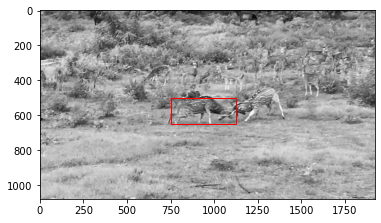

In [15]:
num_iters = 10
threshold = 0.01
seq = np.load('../out/extra_cred.npy')
print(seq.shape)
rect = [750, 500, 1125, 650]
It = seq[:,:,0]
w = rect[2] - rect[0]
h = rect[3] - rect[1]
print(w, h)

# Initial frame
# plt.figure()
# currentAxis = plt.gca()
# rect_draw_It1 = patches.Rectangle((rect[0], rect[1]), w, h, linewidth=1, edgecolor='r', facecolor='none')
# currentAxis.add_patch(rect_draw_It1)

# TODO: run LK and update template and plot 
#----------------------------------------------------------------------------------------------
# plt.figure()
# for i in range(100):
#     It1 = seq[:, :, i]
#     p = LucasKanade(It, It1, rect, threshold, num_iters, p0=np.zeros(2))
#     rect = [rect[0] + p[0], rect[1] + p[1], rect[2] + p[0], rect[3] + p[1]]
#     It = It1
    
    
plt.figure()
currentAxis = plt.gca()

It1 = seq[:,:,0]
plt.imshow(It1, cmap='gray')
# plt.axis('off')

rect_draw_It1 = patches.Rectangle((rect[0], rect[1]), w, h, linewidth=1, edgecolor='r', facecolor='none')
# print(rect_draw_It1)

currentAxis.add_patch(rect_draw_It1)
plt.imshow(It1, cmap='gray')
plt.show()
# ----------------------------------------------------------------------------------------------

In [23]:
# We recommend using this function, but you can explore other methods as well (e.g., ndimage.shift).
from scipy.interpolate import RectBivariateSpline as RBS

# The function below could be useful as well :) 
from numpy.linalg import lstsq

def LucasKanade(It, It1, rect, threshold, num_iters, p0=np.zeros(2)):
    """
    :param[np.array(H, W)] It   : Image frame at time-step t
    :param[np.array(H, W)] It1  : Image frame at time-step t+1
    :param[np.array(4, 1)] rect : Coordinates of template which has the form [x1, y1, x2, y2], where
                                  [x1, y1] is the top-left, and [x2, y2] is the bottom-right corner.  
    :param[float] dp_thresh     : If the length of dp < threshold, terminate the optimization
    :param[int] num_iters       : Number of iterations for running the optimization
    :param[np.array(2, 1)] p0   : Initial movement vector [dp_x0, dp_y0]

    :return[np.array(2, 1)] p   : Final movement vector [dp_x, dp_y]
    """
	
    # Initialize p to p0. Don't remove these lines.
    p = p0
    delta_p = np.ones((1,2))

    # ----------------------------------------------------------------------------------------------
    # TODO: Add your LK implementation here: 
    dp_thresh = 1
    i = 0
    
    It_spline = RBS(np.arange(It.shape[0]), np.arange(It.shape[1]), It)
    It1_spline = RBS(np.arange(It1.shape[0]), np.arange(It1.shape[1]), It1)
    
    x = np.linspace(rect[0], rect[2], 188)
    y = np.linspace(rect[1], rect[3], 76)
    x_mesh, y_mesh = np.meshgrid(x, y)
    It_inter = It_spline.ev(y_mesh, x_mesh).flatten()

    
    while (i <= num_iters) and (dp_thresh >= threshold):
        #Derivatives
        xp = np.linspace(rect[0] + p[0], rect[2] + p[0], 188)
        yp = np.linspace(rect[1] + p[1], rect[3] + p[1], 76)
        xp_mesh, yp_mesh = np.meshgrid(xp, yp)
        It1_inter = It1_spline.ev(yp_mesh, xp_mesh).flatten()
    
        It1_grad_x = It1_spline.ev(yp_mesh, xp_mesh, dx = 1, dy = 0).flatten()
        It1_grad_y = It1_spline.ev(yp_mesh, xp_mesh, dx = 0, dy = 1).flatten()
        
        A = np.zeros((It1_grad_x.shape[0], 2))
        
        A[:, 0] = It1_grad_y
        A[:, 1] = It1_grad_x

        # print(A.shape)
        
        b = It_inter - It1_inter
        
        
        delta_p,_,_,_ = lstsq(A, b, rcond = None)

        p += delta_p
        
        dp_thresh = np.linalg.norm(delta_p)
             
        i += 1
    
#     print("Final p:", p)
    # ----------------------------------------------------------------------------------------------
    return p

In [24]:
def TrackSequenceWithTemplateCorrection(seq, rect_0, num_iters, lk_threshold, drift_threshold):
    """
    :param[np.array(H, W, N)] seq : sequence of frames
    :param[np.array(4, 1)] rect   : Coordinates of template which has the form [x1, y1, x2, y2], where
                                    [x1, y1] is the top-left, and [x2, y2] is the bottom-right corner.  
    :param[int] num_iters         : Number of iterations for running the optimization
    :param[float] dp_thresh       : If the length of dp < threshold, terminate the optimization
    :param[float] drift_threshold : float, threshold for the template update.

    :return[np.array(N, 4)] rects : Coordinates for the template at each frame in the sequence.
    """
    H, W, N = seq.shape
    rect = np.copy(rect_0)
    rects_wtcr =[rect_0]
    
    It = seq[:,:,0]
    It0 = seq[:,:,0]
    
    print(It.shape)
    # ----------------------------------------------------------------------------------------------
    # TODO: Iterate over the sequence to track the object in of interest and do template correction.
    #  Add your code here:
    
    p_star_prev = np.zeros(2)
    
    for i in tqdm(range(1, seq.shape[2])):
#         print("iteration number:", i)
        It1 = seq[:, :, i]
        
#         print("It1 shape:", It1.shape)
        It1_spline = RBS(np.arange(It1.shape[0]), np.arange(It1.shape[1]), It1)
        
        p = LucasKanade(It, It1, rect, lk_threshold, num_iters, p0 = np.zeros(2))
        p_star = LucasKanade(It0, It1, rect_0, lk_threshold, num_iters, p_star_prev)

        tmp_rect2 = rect.copy()
        p_tot = np.zeros(2)
        p_tot[0] = p[0] + rect[0] - rect_0[0]
        p_tot[1] = p[1] + rect[1] - rect_0[1]

        
        if (np.linalg.norm(p_star - p_tot) <= drift_threshold):            
            tmp_rect2[0] = rect_0[0] + p_star[0]
            tmp_rect2[1] = rect_0[1] + p_star[1]
            tmp_rect2[2] = rect_0[2] + p_star[0]
            tmp_rect2[3] = rect_0[3] + p_star[1]

            It = It1
            
        
        rects_wtcr.append(tmp_rect2[:])
        rect = tmp_rect2
        p_star_prev = p_star

    # ----------------------------------------------------------------------------------------------
    rects_wtcr = np.array(rects_wtcr)
    # Just a sanity check
    assert rects_wtcr.shape == (N, 4), f"Your output sequence {rects_wtcr.shape} is not {N}x{4}"
    return rects_wtcr

In [30]:
#Creating rectangles
seq = np.load('../out/extra_cred.npy')
# seq_test = seq[:,:,:50]
rect = [750, 500, 1125, 650]
num_iters = 10
threshold = 1e-2
drift_threshold = 2

rects = TrackSequenceWithTemplateCorrection(seq, rect, num_iters, threshold, drift_threshold)
np.save("../out/extracredseqrects-wtcr.npy", rects)

(1080, 1920)


100%|██████████| 269/269 [12:24<00:00,  2.77s/it]


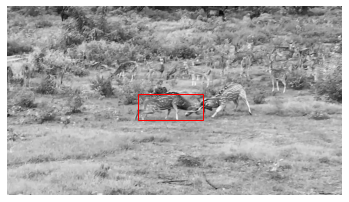

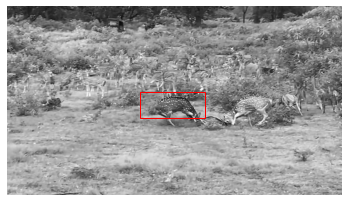

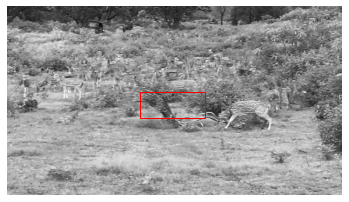

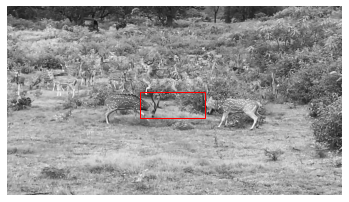

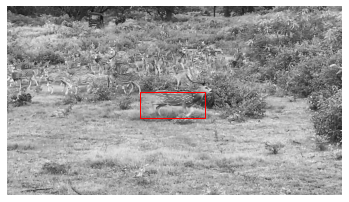

In [31]:
frames_to_save = [0, 50, 75, 100, 200]

rects_wtcr = np.load("../out/extracredseqrects-wtcr.npy")
# rects = np.load("../out/carseqrects.npy")

for idx in frames_to_save:
    rect_wtcr = rects_wtcr[idx]
    # rect = rects[idx]
    frame = seq[:, :, idx]
    w = rect_wtcr[2] - rect_wtcr[0]
    h = rect_wtcr[3] - rect_wtcr[1]

    plt.figure()
    currentAxis = plt.gca()
    rect_wtcr_draw = patches.Rectangle(
        (rect_wtcr[0], rect_wtcr[1]), w, h, linewidth=1, edgecolor='r', facecolor='none')
    currentAxis.add_patch(rect_wtcr_draw)
    
    # rect_draw = patches.Rectangle(
    #     (rect[0], rect[1]), w, h, linewidth=1, edgecolor='b', facecolor='none')
    # currentAxis.add_patch(rect_draw)
    
    plt.imshow(frame, cmap='gray')
    plt.axis('off')
    plt.savefig(f"../out/sol_4_deerseq_{idx+1}.png")